In [ ]:
# Admin functions
# https://ipython.org/ipython-doc/dev/config/extensions/autoreload.html
%load_ext autoreload
# When modules are changed externally, uses latest version
%autoreload 2
# Lanches a console for interaction with this kernel (for testing)
%qtconsole
# If you get an error here, try running conda install ipyparallel and running again

# Coursework #1

## Introduction

This coursework is concerned with building multi-layer networks to address the MNIST digit classification problem. It builds on the previous labs, in particular [02_MNIST_SLN.ipynb](02_MNIST_SLN.ipynb) in which single layer networks were trained for MNIST digit classification.   The course will involve extending that code to use Sigmoid and Softmax layers, combining these into multi-layer networks, and carrying out a number of MNIST digit classification experiments, to investigate the effect of learning rate, the number of hidden units, and the number of hidden layers.

The coursework is divided into 4 tasks:
* **Task 1**:   *Implementing a sigmoid layer* - 15 marks.  
This task involves extending the `Linear` class in file `mlp/layers.py` to `Sigmoid`, with code for forward prop, backprop computation of the gradient, and weight update.
* **Task 2**:  *Implementing a softmax layer* - 15 marks.  
This task involves extending the `Linear` class in file `mlp/layers.py` to `Softmax`, with code for forward prop, backprop computation of the gradient, and weight update.
* **Task 3**:  *Constructing a multi-layer network* - 40 marks.  
This task involves putting together a Sigmoid and a Softmax layer to create a multi-layer network, with one hidden layer (100 units) and one output layer, that is trained to classify MNIST digits.  This task will include reporting classification results, exploring the effect of learning rates, and plotting Hinton Diagrams for the hidden units and output units.
* **Task 4**:  *Experiments with different architectures*  - 30 marks.  
This task involves further MNIST classification experiments, primarily looking at the effect of using different numbers of hidden layers.
The coursework will be marked out of 100, and will contribute 30% of the total mark in the MLP course.

## Previous Tutorials

Before starting this coursework make sure that you have completed the first three labs:

* [00_Introduction.ipynb](00_Introduction.ipynb) - setting up your environment; *Solutions*: [00_Introduction_solution.ipynb](00_Introduction_solution.ipynb)
* [01_Linear_Models.ipynb](01_Linear_Models.ipynb) - training single layer networks; *Solutions*: [01_Linear_Models_solution.ipynb](01_Linear_Models_solution.ipynb)
* [02_MNIST_SLN.ipynb](02_MNIST_SLN.ipynb) - training a single layer network for MNIST digit classification

To ensure that your virtual environment is correct, please see [this note](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/kernel_issue_fix.md) on the GitHub.
## Submission
**Submission Deadline:  Thursday 29 October, 16:00** 

Submit the coursework as an ipython notebook file, using the `submit` command in the terminal on a DICE machine. If your file is `03_MLP_Coursework1.ipynb` then you would enter:

`submit mlp 1 03_MLP_Coursework1.ipynb` 

where `mlp 1` indicates this is the first coursework of MLP.

After submitting, you should receive an email of acknowledgment from the system confirming that your submission has been received successfully. Keep the email as evidence of your coursework submission.

**Please make sure you submit a single `ipynb` file (and nothing else)!**

**Submission Deadline:  Thursday 29 October, 16:00** 



## Getting Started
Please enter your exam number and the date in the next code cell.

In [ ]:
#MLP Coursework 1
#Exam number: B058714
#Date: 20/10/2015

Please run the next code cell, which imports `numpy` and seeds the random number generator.  Please **do not** modify the random number generator seed!

In [1]:
import numpy

#Seed a random number generator running the below cell, but do **not** modify the seed.
rng = numpy.random.RandomState([2015,10,10])
rng_state = rng.get_state()

## Task 1 - Sigmoid Layer (15%)

In this task you need to create a class `Sigmoid` which encapsulates a layer of sigmoid units.  You should do this by extending the `mlp.layers.Linear` class (in file `mlp/layers.py`), which implements a layer of linear units (i.e. weighted sum plus bias).  The `Sigmoid` class extends this by applying the sigmoid transfer function to the weighted sum in the forward propagation, and applying the derivative of the sigmoid in the gradient descent back propagation and computing the gradients with respect to layer's parameters. Do **not** copy the implementation provided in `Linear` class but rather, **reuse** it through inheritance.

When you have implemented `Sigmoid` (in the `mlp.layers` module), then please test it by running the below code cell.


In [2]:
from mlp.layers import Sigmoid

a = numpy.asarray([-20.1, 52.4, 0, 0.05, 0.05, 49])
b = numpy.asarray([-20.1, 52.4, 0, 0.05, 0.05, 49, 20, 20])

rng.set_state(rng_state)
sigm = Sigmoid(idim=a.shape[0], odim=b.shape[0], rng=rng)

fp = sigm.fprop(a)
deltas, ograds  = sigm.bprop(h=fp, igrads=b)

print fp.sum()
print deltas.sum()
print ograds.sum()
%precision 3
print fp
print deltas
print ograds


4.21941537867
25.9255147706
4.1105500626
[ 0.067  0.728  0.999  0.512  0.159  0.584  0.238  0.932]
[ -1.263e+00   1.037e+01   0.000e+00   1.249e-02   6.678e-03   1.191e+01
   3.628e+00   1.268e+00]
[ 1.406  0.078 -0.268  0.418  1.646  0.831]


***
To include the `Sigmoid` code in the notebook please run the below code cell.  (The `%load` notebook command is used to load the source of the `Sigmoid` class from `mlp/layers.py`.)

In [ ]:
# %load -s Sigmoid mlp/layers.py
class Sigmoid(Linear):
    
    def get_name(self):
        return 'sigmoid'
    
    ## Showing I could roll my own
    # def sigmoid(self, X):
    #     return 1. / (1 + numpy.exp(-X))
    # expit is 10x faster http://stackoverflow.com/questions/21106134/numpy-pure-functions-for-performance-caching
    def sigmoid(self, X):
        return expit(X)
    
    def fprop(self, inputs):
        a = super(Sigmoid, self).fprop(inputs)
        return self.sigmoid(a)
    
    def bprop(self, h, igrads):
        # h = Sigmoid(a) = 1. / (1 + numpy.exp(-a))
        # dh/da = numpy.exp(-a) / (1 + numpy.exp(-a))**2
        #       = h(1-h)
        deltas = igrads * h * (1-h)
        ograds = deltas.dot(self.W.T)
        return deltas, ograds
    
    def bprop_cost(self, h, igrads, cost):
        if cost is None or cost.get_name() == 'ce':
            # for Sigmoid layer and cross entropy cost,
            # cost back-prop is the same as standard back-prop
            return self.bprop(h, igrads)
        else:
            raise NotImplementedError('Linear.bprop_cost method not implemented '
                                      'for the %s cost' % cost.get_name())


## Task 2 - Softmax (15%)

In this task you need to create a class `Softmax` which encapsulates a layer of softmax units.  As in the previous task, you should do this by extending the `mlp.layers.Linear` class (in file `mlp/layers.py`).

When you have implemented `Softmax` (in the `mlp.layers` module), then please test it by running the below code cell.


In [3]:
from mlp.layers import Softmax

a = numpy.asarray([-20.1, 52.4, 0, 0.05, 0.05, 49])
b = numpy.asarray([0, 0, 0, 0, 0, 0, 0, 1])

rng.set_state(rng_state)
softmax = Softmax(idim=a.shape[0], odim=b.shape[0], rng=rng)

fp = softmax.fprop(a)
deltas, ograds = softmax.bprop_cost(h=None, igrads=fp-b, cost=None)

print fp.sum()
print deltas.sum()
print ograds.sum()
%precision 3
print fp
print deltas
print ograds


1.0
0.0
0.0744177068753
[[  4.571e-05   1.697e-03   9.877e-01   6.631e-04   1.194e-04   8.880e-04
    1.977e-04   8.671e-03]]
[[  4.571e-05   1.697e-03   9.877e-01   6.631e-04   1.194e-04   8.880e-04
    1.977e-04  -9.913e-01]]
[[-0.089  0.03   0.079  0.011  0.017  0.027]]


***
To include the `Softmax` code in the notebook please run the below code cell.  (The notebook `%load` command is used to load the source of the `Softmax` class from `mlp/layers.py`.)

In [ ]:
# %load -s Softmax mlp/layers.py
class Softmax(Linear):
    def get_name(self):
        return 'softmax'
    
    def softmax(self, X):
        ## For matrices
        ex = numpy.exp(X)
        # Hack for a batch of size 1...must be a better way to deal with this
        if ex.ndim == 1:
            ex = ex[numpy.newaxis, :]
        tot = numpy.sum(ex, axis=1, keepdims=True)
        assert(tot.shape[0] == ex.shape[0]), \
            "Total of exponents should be size N. Sum size %d, N from X is %d" % (tot.shape[0], ex.shape[0])
        return ex / tot
#         ex = numpy.exp(x)
#         tot = numpy.sum(ex)
#         return ex / tot
    
    def fprop(self, inputs):
        a = super(Softmax, self).fprop(inputs)
        return self.softmax(a)
    
    # TODO: should probably NotImplementedError bprop and edit bprop_cost
    def bprop(self, h, igrads):
        # h = Softmax(a) = np.exp(a) / np.sum(np.exp(a))
        # dh_c/da_k = h_c(\dirac_ck - h_k)  #NB a matrix
        # see end of lecture notes mlp05-hid
        # USE AS TOP LAYER ONLY
        ograds = numpy.dot(igrads, self.W.T)
        return igrads, ograds
        
    def bprop_cost(self, h, igrads, cost):
        if cost is None or cost.get_name() == 'ce':
            # for softmax layer and cross entropy cost,
            # cost back-prop is the same as standard back-prop
            return self.bprop(h, igrads)
        else:
            raise NotImplementedError('Linear.bprop_cost method not implemented '
                                      'for the %s cost' % cost.get_name())
        return deltas, ograds


## Task 3 - Multi-layer network for MNIST classification (40%)

**(a)** (20%)  Building on the single layer linear network for MNIST classification used in lab [02_MNIST_SLN.ipynb](02_MNIST_SLN.ipynb), and using the `Sigmoid` and `Softmax` classes that you implemented in tasks 1 and 2, construct and learn a model that classifies MNIST images and:
   * Has one hidden layer with a sigmoid transfer function and 100 units
   * Uses a softmax output layer to discriminate between the 10 digit classes (use the `mlp.costs.CECost()` cost)

Your code should print the final values of the error function and the classification accuracy for train, validation, and test sets (please keep also the log information printed by default by the optimiser). Limit the number of training epochs to 30. You can, of course, split your code across as many cells as you think is necessary.

In [4]:
# include here the complete code that constructs the model, performs training,
# and prints the error and accuracy for train/valid/test

import logging
np = numpy

logger = logging.getLogger()
logger.setLevel(logging.INFO)

from mlp.layers import MLP, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser
from mlp.dataset import MNISTDataProvider #import data provider
from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed

rng = np.random.RandomState([2015,10,10])
cost = CECost()
model = MLP(cost=cost)
model.add_layer(Sigmoid(idim=784, odim=100, rng=rng))
model.add_layer(Softmax(idim=100, odim=10, rng=rng))
# define the optimiser, here stochasitc gradient descent
# with fixed learning rate and max_epochs as stopping criterion
lr_scheduler = LearningRateFixed(learning_rate=0.01, max_epochs=30)
optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

logger.info('Initialising data providers...')
train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-1, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-1, randomize=False)

logger.info('Training started...')
tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

logger.info('Testing the model on test set:')
test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-1, randomize=False)
cost, accuracy = optimiser.validate(model, test_dp)
logger.info('MNIST test set accuracy is %.2f %% (cost is %.3f)'%(accuracy*100., cost))

INFO:root:Initialising data providers...
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for random model is 2.344. Accuracy is 12.43%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for random model is 2.344. Accuracy is 12.92%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 2.214. Accuracy is 37.87%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 2.106. Accuracy is 57.72%
INFO:mlp.optimisers:Epoch 1: Took 3 seconds. Training speed 19301 pps. Validation speed 37438 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 1.978. Accuracy is 61.20%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 1.817. Accuracy is 66.45%
INFO:mlp.optimisers:Epoch 2: Took 3 seconds. Training speed 18959 pps. Validation speed 35206 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 1.660. Accuracy is 68.08%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 1.472. Accuracy is 73.55%
INFO:mlp.optimisers:Epoch 3: Took 3 seconds. Training speed 19400 pps. Va

**(b)** (10%) Investigate the impact of different learning rates $\eta \in \{0.5, 0.2, 0.1, 0.05, 0.01, 0.005\}$ on the convergence of the network training as well as the final accuracy:
   * Plot (on a single graph) the error rate curves for each learning rate as a function of training epochs for training set
   * Plot (on another single graph) the error rate curves as a function of training epochs for validation set
   * Include a table of the corresponding error rates for test set

The notebook command `%matplotlib inline` ensures that your graphs will be added to the notebook, rather than opened as additional windows.

In [10]:
# Learning rates to test
# ======================
learning_rates = [0.5, 0.2, 0.1, 0.05, 0.01, 0.005]
max_epochs = 30

# Create model objects
# ====================
import numpy as np
from mlp.layers import MLP, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser
from mlp.dataset import MNISTDataProvider #import data provider
from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed
from copy import deepcopy

rng = np.random.RandomState([2015,10,10])
cost = CECost()
model = MLP(cost=cost)
model.add_layer(Sigmoid(idim=784, odim=100, rng=rng))
model.add_layer(Softmax(idim=100, odim=10, rng=rng))
train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-1, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-1, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-1, randomize=False)

constantParams = {
    'model': model,
    'train_dp': train_dp,
    'valid_dp': valid_dp,
    'test_dp': test_dp
}

grid = [
    dict(
        deepcopy(constantParams).items() +
        [
            ('learning_rate', learning_rate),
            ('lr_scheduler', LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)),
            ('tr_stats', []),
            ('valid_stats', []),
            ('test_cost', None),
            ('test_accuracy', None)
        ]
    )
    for learning_rate in learning_rates
]

In [11]:
# Training
# ========
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

for config in grid:
    optimiser = SGDOptimiser(lr_scheduler=config['lr_scheduler'])
    logger.info('Training started with learning rate %0.3f' % config['learning_rate'])
    config['tr_stats'], config['valid_stats'] = \
        optimiser.train(config['model'], config['train_dp'], config['valid_dp'])
    logger.info('Testing the model on test set:')
    config['test_cost'], config['test_accuracy'] = \
        optimiser.validate(config['model'], config['test_dp'])
    logger.info('MNIST test set accuracy is %.2f %% (cost is %.3f)' % \
                (config['test_accuracy']*100., config['test_cost']))

INFO:root:Training started with learning rate 0.500
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for random model is 2.344. Accuracy is 12.43%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for random model is 2.344. Accuracy is 12.92%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.576. Accuracy is 83.47%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.287. Accuracy is 91.76%
INFO:mlp.optimisers:Epoch 1: Took 2 seconds. Training speed 22159 pps. Validation speed 47303 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.287. Accuracy is 91.65%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.240. Accuracy is 93.19%
INFO:mlp.optimisers:Epoch 2: Took 2 seconds. Training speed 22224 pps. Validation speed 46430 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.235. Accuracy is 93.16%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.204. Accuracy is 94.29%
INFO:mlp.optimisers:Epoch 3: Took 2 seconds. Training speed 22362 pps. Validation speed 4792

,learning_rate,test_cost,test_accuracy
0,0.500,0.076950,0.9768
1,0.200,0.100818,0.9704
2,0.100,0.144329,0.9577
3,0.050,0.203264,0.9407
4,0.010,0.340387,0.9057
5,0.005,0.453201,0.8866


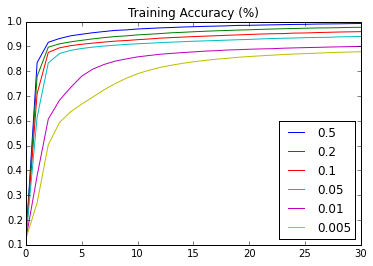

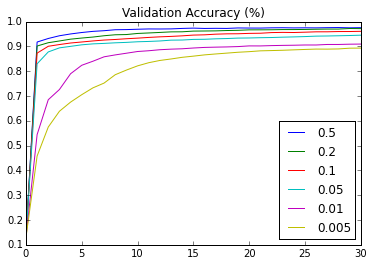

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# Plot (on a single graph) the error rate curves for each learning rate as a function of training epochs for training set
tmp = [m['tr_stats'] for m in grid]
df = pd.DataFrame(np.array([np.array(i)[:,1] for i in tmp]).T, columns=learning_rates)
df.plot().set_title('Training Accuracy (%)')
plt.savefig("/Users/kungfujam/git/mlpractical/data/figures/training_accuracy.eps", dpi=300)

# Plot (on another single graph) the error rate curves as a function of training epochs for validation set
tmp = [m['valid_stats'] for m in grid]
df = pd.DataFrame(np.array([np.array(i)[:,1] for i in tmp]).T, columns=learning_rates)
df.plot().set_title('Validation Accuracy (%)')
plt.savefig("/Users/kungfujam/git/mlpractical/data/figures/validation_accuracy.eps", dpi=300)

# Include a table of the corresponding error rates for test set
testres = pd.DataFrame(grid)[['learning_rate', 'test_cost', 'test_accuracy']]
testres

# plt.subplot(211)
# for learning_rate
# plt.plot([1,2,3], label="test1")
# plt.plot([3,2,1], label="test2")
# # Place a legend above this legend, expanding itself to
# # fully use the given bounding box.
# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)

# plt.subplot(223)
# plt.plot([1,2,3], label="test1")
# plt.plot([3,2,1], label="test2")
# # Place a legend to the right of this smaller figure.
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.show()

_The training and validation accuracy increase as the learning increased. The test set accuracy is best for the fastest learning rate. This suggests we may need to run the models for longer to see benefits of lower rates._

**(c)** (10%) Plot the following graphs:
  * Display the 784-element weight vector of each of the 100 hidden units as 10x10 grid plot of 28x28 images, in order to visualise what features of the input they are encoding.  To do this, take the weight vector of each hidden unit, reshape to 28x28, and plot using the `imshow` function).
  * Plot a Hinton Diagram of the output layer weight matrix for digits 0 and 1

_Function `hinton` adapted from the matplotlib examples_

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x,y),w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [ ]:
sigmoid_Ws = [config['model'].layers[0].W for config in grid]

# So that all plots are relative, find the min and max values over all models
max_w = np.max([(np.max(W), np.min(W)) for W in sigmoid_Ws])
min_w = np.min([(np.max(W), np.min(W)) for W in sigmoid_Ws])

plt.close('all')
for i, W in enumerate(sigmoid_Ws):
    fig, axList = plt.subplots(10, 10)  # There are 100 weights in the layer
    fig.set_size_inches(14, 14)
    axList = axList.flatten()
    for j, ax in enumerate(axList):
        hinton(W[:,j].reshape(28,28), max_weight=max_w, ax=ax)
    fig.suptitle("Model weights for learning rate %0.3f" % learning_rates[i])
    fig.savefig("/Users/kungfujam/git/mlpractical/data/figures/sig_weights_hinton__lr%0.3f.eps" \
                %learning_rates[i], dpi=300)
    plt.close('all')

**(c)** (cont.) (10%) Plot the following graphs:
    * Plot a Hinton Diagram of the output layer weight matrix for digits 0 and 1

In [ ]:
softmax_Ws = [config['model'].layers[1].W for config in grid]

plt.close('all')
for i, W in enumerate(softmax_Ws):
    fig, axList = plt.subplots(1, 2)  # we only want to show two weight matrices:
    fig.set_size_inches(14, 14)       #   the first couple - zero and one
    axList = axList.flatten()
    for j, ax in enumerate(axList):
        hinton(W[:,j].reshape(10,10), max_weight=max_w, ax=ax)
    fig.suptitle("Model weights for learning rate %0.3f" % learning_rates[i])
    fig.savefig("/Users/kungfujam/git/mlpractical/data/figures/soft_weights_hinton__lr%0.3f.eps" \
                %learning_rates[i], dpi=300)
    plt.show()
    plt.close('all')
# TODO: what you really want to do is show a weighted sum of the hidden units...

## Task 4 - Experiments with 1-5 hidden layers (30%)

In this task use the learning rate which resulted in the best accuracy in your experiments in Task 3 (b).  Perform the following experiments:

  * Train a similar model to Task 3, with one hidden layer, but with 800 hidden units. 
  * Train 4 additional models with 2, 3, 4 and 5 hidden layers.  Set the number of hidden units for each model, such that all the models have similar number of trainable weights ($\pm$2%).   For simplicity, for a given model, keep the number of units in each hidden layer the same.
  * Plot value of the error function for training and validation sets as a function of training epochs for each model
  * Plot the test set classification accuracy as a function of the number of hidden layers


```Mathematica
In[1]:= DD = 784           (* Input *);
K = 10                     (* Output *);
H1 = 800                   (* First config hidden nodes *);
P = DD H1 + H1 K + H1 + K  (* Parameters (inc. bias) *)

Out[4]= 636010

In[5]:= NSolve[DD*H + H^2 + H*K + DD + 2*H == P, H]

Out[5]= {{H -> -1288.86}, {H -> 492.859}}

In[6]:= NSolve[DD*H + 2*H^2 + H * K + DD + 3*H == P, H]

Out[6]= {{H -> -797.007}, {H -> 398.507}}

In[7]:= NSolve[DD*H + 3*H^2 + H * K + DD + 4*H == P, H]

Out[7]= {{H -> -611.99}, {H -> 345.99}}

In[8]:= NSolve[DD*H + 4*H^2 + H * K + DD + 5*H == P, H]

Out[8]= {{H -> -510.705}, {H -> 310.955}}
```

In [ ]:
max_epochs = 30
learning_rate = 0.5

# Create model objects
# ====================
import numpy as np
from mlp.layers import MLP, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser
from mlp.dataset import MNISTDataProvider #import data provider
from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed
from copy import deepcopy

rng = np.random.RandomState([2015,10,10])

# Model 1
# =======
nr_nodes = 800
cost1 = CECost()
model1 = MLP(cost=cost1)
model1.add_layer(Sigmoid(idim=784, odim=nr_nodes, rng=rng))
model1.add_layer(Softmax(idim=nr_nodes, odim=10, rng=rng))

# Model 2
# =======
nr_nodes = 493
cost2 = CECost()
model2 = MLP(cost=cost2)
model2.add_layer(Sigmoid(idim=784, odim=nr_nodes, rng=rng))
model2.add_layer(Sigmoid(idim=nr_nodes, odim=nr_nodes, rng=rng))
model2.add_layer(Softmax(idim=nr_nodes, odim=10, rng=rng))

# Model 3
# =======
nr_nodes = 399
cost3 = CECost()
model3 = MLP(cost=cost3)
model3.add_layer(Sigmoid(idim=784, odim=nr_nodes, rng=rng))
model3.add_layer(Sigmoid(idim=nr_nodes, odim=nr_nodes, rng=rng))
model3.add_layer(Sigmoid(idim=nr_nodes, odim=nr_nodes, rng=rng))
model3.add_layer(Softmax(idim=nr_nodes, odim=10, rng=rng))

# Model 4
# =======
nr_nodes = 346
cost4 = CECost()
model4 = MLP(cost=cost4)
model4.add_layer(Sigmoid(idim=784, odim=nr_nodes, rng=rng))
model4.add_layer(Sigmoid(idim=nr_nodes, odim=nr_nodes, rng=rng))
model4.add_layer(Sigmoid(idim=nr_nodes, odim=nr_nodes, rng=rng))
model4.add_layer(Sigmoid(idim=nr_nodes, odim=nr_nodes, rng=rng))
model4.add_layer(Softmax(idim=nr_nodes, odim=10, rng=rng))

# Model 5
# =======
nr_nodes = 311
cost5 = CECost()
model5 = MLP(cost=cost5)
model5.add_layer(Sigmoid(idim=784, odim=nr_nodes, rng=rng))
model5.add_layer(Sigmoid(idim=nr_nodes, odim=nr_nodes, rng=rng))
model5.add_layer(Sigmoid(idim=nr_nodes, odim=nr_nodes, rng=rng))
model5.add_layer(Sigmoid(idim=nr_nodes, odim=nr_nodes, rng=rng))
model5.add_layer(Softmax(idim=nr_nodes, odim=10, rng=rng))

models = [model1, model2, model3, model4, model5]
# Data
# ====
train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-1, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-1, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-1, randomize=False)

constantParams = {
    'train_dp': train_dp,
    'valid_dp': valid_dp,
    'test_dp': test_dp,
    'lr_scheduler': LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
}

grid = [
    dict(
        deepcopy(constantParams).items() +
        [
            ('model', model),
            ('learning_rate', learning_rate),
            ('tr_stats', []),
            ('valid_stats', []),
            ('test_cost', None),
            ('test_accuracy', None)
        ]
    )
    for models in models
]

In [ ]:
# Training
# ========
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

for i, config in enumerate(grid):
    optimiser = SGDOptimiser(lr_scheduler=config['lr_scheduler'])
    logger.info('Training Model %d started with learning rate %0.3f' % \
                (i, config['learning_rate']))
    config['tr_stats'], config['valid_stats'] = \
        optimiser.train(config['model'], config['train_dp'], config['valid_dp'])
    logger.info('Testing the model on test set:')
    config['test_cost'], config['test_accuracy'] = \
        optimiser.validate(config['model'], config['test_dp'])
    logger.info('MNIST test set accuracy is %.2f %% (cost is %.3f)' % \
                (config['test_accuracy']*100., config['test_cost']))

This is the end of coursework 1.

Please remember to save your notebook, and submit your notebook following the instructions at the top.  Please make sure that you have executed all the code cells when you submit the notebook.
